In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint
import pandas as pd

# Areas Covered

- https://en.wikipedia.org/wiki/Valle_del_Cauca_Department
  - 4,532,152
- https://en.wikipedia.org/wiki/Nari%C3%B1o_Department
  - 1,627,589
- https://en.wikipedia.org/wiki/Putumayo_department
  - 359,127
- Total: 6,518,868 

Rough Mission Area: 3,000,000

In [3]:
def model_unsdb(params, y0, ts, periodic=False):
    alpha, beta, gamma, delta, epsilon, eta, kappa, lamb, omega = params

    def unsdb(t, y):
        # Unconctacted, New People, Sacrament Attendance, Date, Baptized
        U, N, S, D, B = y
        if periodic:
            alpha_t = np.sin(alpha * t + 3 / 2 * np.pi) + 1
        else:
            alpha_t = alpha
        return np.array(
            [
                lamb*N - alpha*B*U + eta*U,
                alpha*B*U + kappa*S - (beta + lamb)*N,
                beta*N + gamma*D - (delta + kappa)*S,
                delta*S - (epsilon + gamma)*D,
                epsilon*D + omega*B
            ]
        )

    # Solve
    sol = solve_ivp(unsdb, (0, ts[-1]), y0, t_eval=ts)
    if not sol.success:
        return np.zeros((len(y0), len(ts)))
    return sol.y

In [4]:
labels = ["Uncontacted", "New People", "Sacrament", "Date", "Baptized"]


def plot_solutions_separate(ts, y_hat, population, title="Modeled Data"):
    fig, axes = plt.subplots(5, figsize=(4, 6), gridspec_kw={"wspace": 0.5})

    for ax, label, i in zip(axes, labels, range(len(labels))):
        ax.plot(ts / 52, y_hat[i] * population)
        ax.ticklabel_format(style="plain", useOffset=False)
        ax.annotate(
            label,
            xy=(1, 0.5),
            xycoords="axes fraction",
            xytext=(10, 0),
            textcoords="offset points",
            ha="left",
            va="center",
            fontsize=10,
        )  # Adjust text position
        if ax != axes[-1]:  # Check if it's not the bottom subplot
            ax.label_outer()  # Hide x-axis labels and ticks
    plt.tight_layout()
    plt.suptitle(title)


def plot_solutions_together(ts, y_hat, population, title="Modeled Data"):
    for i, label in enumerate(labels):
        if label == "Uncontacted":
            continue
        plt.plot(ts / 52, y_hat[i] * population, label=label)
    plt.title(title)
    plt.xlabel("Time (years)")
    plt.ylabel("People")
    plt.legend()
    plt.ticklabel_format(style="plain", useOffset=False)

/tmp/ipykernel_32628/1603550079.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


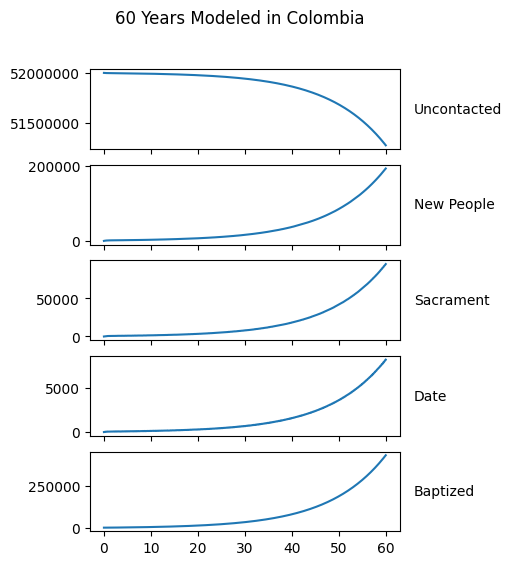

In [16]:
init_members = 3_000
population = 52_000_000
init_U = population - init_members
alpha = (100 * population) / (init_U * init_members)  # Rate going from Date to Baptized
beta = 1 / 4                                          # Rate going from New People to Sacrament
delta = 1 / 20                                        # Rate going from Sacrament to Date
epsilon = 1 / 12                                      # Rate going from Date to Baptized
gamma = 1 / 2                                         # Rate going from Date to Sacrament
kappa = 1 / 2                                         # Rate going from Sacrament to Teaching
lamb = 1 / 15                                         # Rate going from Teaching to Uncontacted
eta = 0 #0.000337 - 0.00015
omega = 0 #0.000337 - 0.00015

params = (alpha, beta, gamma, delta, epsilon, eta, kappa, lamb, omega)

t0 = 0
tf = 52 * 60
ts = np.linspace(t0, tf, 1000)

y0 = np.array([init_U / population, 0, 0, 0, init_members / population])
y_hat = model_unsdb(params, y0, ts)
plot_solutions_separate(ts, y_hat, population, "60 Years Modeled in Colombia")

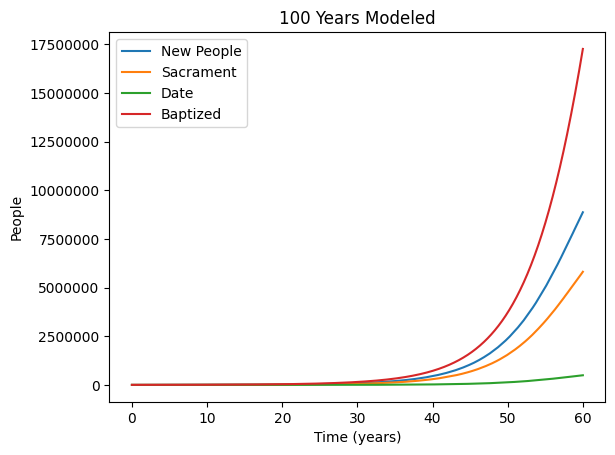

In [6]:
plot_solutions_together(ts, y_hat, population, "100 Years Modeled")

In [7]:
colombia = pd.read_csv("colombia.csv").to_numpy().T / population
ts = np.arange(0, len(colombia[0]))

In [8]:
def optimize_params(data, init_params, *args, **kwargs):
    def error(params):
        ts = np.arange(0, len(data[0]))
        y_hat = model_unsdb(params, data[:, 0], ts, *args, **kwargs)
        return np.mean(np.linalg.norm(y_hat - data, axis=0))

    # Define bounds for the parameters to be nonnegative
    bounds = [(0, None)] * len(init_params)

    fit = minimize(
        error, 
        params, 
        options={"disp": True},
        bounds=bounds
    )
    y_hat = model_unsdb(fit.x, data[:, 0], ts)
    return ts, y_hat, fit.x

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.32083D-04    |proj g|=  1.87000D-04

At iterate    1    f=  3.33684D-05    |proj g|=  2.14878D-05

At iterate    2    f=  2.91159D-05    |proj g|=  1.74550D-05
  ys=-8.340E-06  -gs= 1.563E-06 BFGS update SKIPPED

At iterate    3    f=  2.85890D-05    |proj g|=  8.85777D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      3     30      4     1     2   8.858D-06   2.859D-05
  F =   2.8588989910125328E-005

CONVERGENCE: NORM

/tmp/ipykernel_32628/1603550079.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


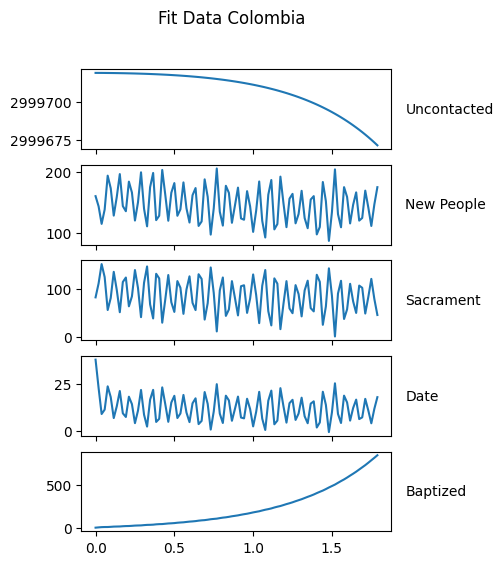

In [9]:
ts, y_hat, fit_params = optimize_params(colombia, params)
print(fit_params)
plot_solutions_separate(ts, y_hat, population, "Fit Data Colombia")

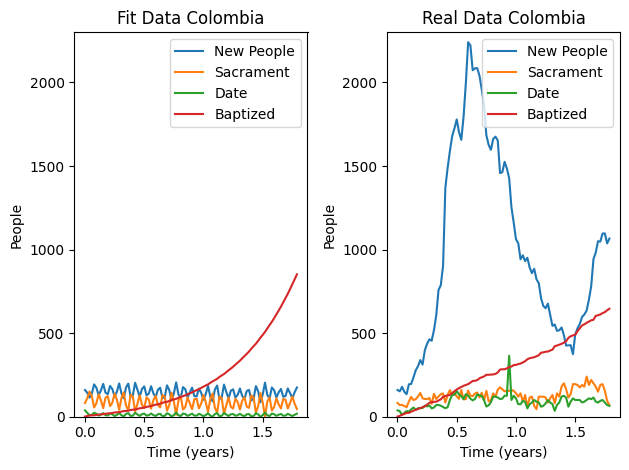

In [10]:
plt.subplot(1, 2, 1)
plt.ylim((0, 2300))
plot_solutions_together(ts, y_hat, population, "Fit Data Colombia")
plt.subplot(1, 2, 2)
plt.ylim((0, 2300))
plot_solutions_together(ts, colombia, population, "Real Data Colombia")
plt.tight_layout()
plt.show()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.32083D-04    |proj g|=  1.87000D-04

At iterate    1    f=  3.33684D-05    |proj g|=  2.14878D-05

At iterate    2    f=  2.91159D-05    |proj g|=  1.74550D-05
  ys=-8.340E-06  -gs= 1.563E-06 BFGS update SKIPPED

At iterate    3    f=  2.85890D-05    |proj g|=  8.85777D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      3     30      4     1     2   8.858D-06   2.859D-05
  F =   2.8588989910125328E-005

CONVERGENCE: NORM

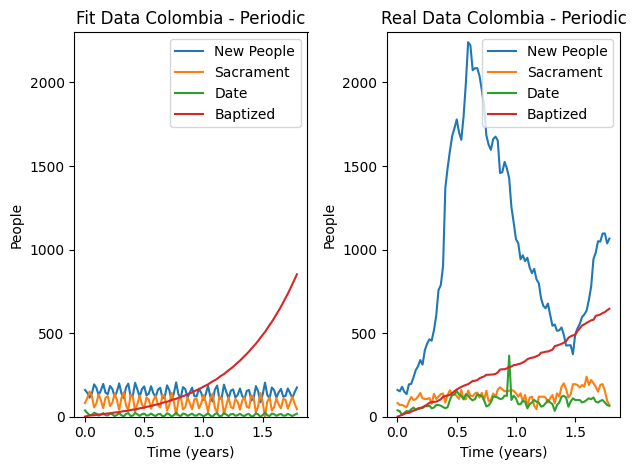

In [11]:
ts, y_hat, fit_params = optimize_params(colombia, params, periodic=True)
print(fit_params)
plt.subplot(1, 2, 1)
plt.ylim((0, 2300))
plot_solutions_together(ts, y_hat, population, "Fit Data Colombia - Periodic")
plt.subplot(1, 2, 2)
plt.ylim((0, 2300))
plot_solutions_together(ts, colombia, population, "Real Data Colombia - Periodic")
plt.tight_layout()
plt.show()